In [1]:
import re
import pickle
import random
import os
import sys

import numpy as np
import pandas as pd
# import hdbscan
# import umap
import sklearn.cluster as cluster
import plotly.express as px
import matplotlib.pyplot as plt
import clusteval
import compress_fasttext

from typing import List
from sklearn.decomposition import PCA
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    silhouette_score
)
from scipy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from stop_words import get_stop_words
from gensim.models import FastText

SEED = 2023
DATA_PATH = '../data/'
MODEL_PATH = '../nlp_model/'
VECTORIZER = compress_fasttext.models.CompressedFastTextKeyedVectors.load(MODEL_PATH + 'small_model_11_18')
NUM_CLUSTERS = 60
SCRIPT_DIR = os.path.dirname(os.path.abspath('./jupyter_hb'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from lib.nlp_utils import Preprocessing
from lib.statictics import calculate_center

In [2]:
with open("../resumes.pickle", "rb") as f:
    new_resumes = pickle.load(f)

In [3]:
random.seed(SEED)

data = (
    pd.DataFrame
    .from_records(new_resumes)
    .assign(
        one_name=lambda df: df['name'].apply(lambda txt: re.split('[,/.]', txt)[0].strip('./!? '))
    )
    .reset_index()
    .rename(columns={'index': 'id'})
)
proc = Preprocessing()
data['tokens_for_clustering'] = proc.process_texts(data, 'one_name')
clustered_data = (
    data
    .loc[data['tokens_for_clustering'].apply(lambda x: len(x) != 0)]
    .assign(
        ft_vectors=lambda df: df['tokens_for_clustering'].apply(
            lambda txt: np.array([VECTORIZER[token] for token in txt]).mean(axis=0)
        )
    )
)[['id', 'one_name', 'ft_vectors']]

ft_vectors = np.concatenate(
    clustered_data['ft_vectors'].values
).reshape(clustered_data.shape[0], -1)

In [4]:
ALGORITHMS = [
    'K-means',
    'Affinity',
    'Spectral',
    'Agglomerative',
    'DBSCAN',
    'MeanShift'
]


def get_scores(algo_names: List[str], vectors: np.ndarray):
    algorithms = []
    
    if 'K-means' in set(algo_names):
        algorithms.append(cluster.KMeans(n_clusters=NUM_CLUSTERS, n_init=10, random_state=SEED))
    if 'Affinity' in set(algo_names):
        algorithms.append(cluster.AffinityPropagation(random_state=SEED))
    if 'Spectral'in set(algo_names):
        algorithms.append(cluster.SpectralClustering(random_state=SEED))
    if 'Agglomerative' in set(algo_names):
        algorithms.append(cluster.AgglomerativeClustering(n_clusters=NUM_CLUSTERS))
    if 'DBSCAN' in set(algo_names):
        algorithms.append(cluster.DBSCAN())
    if 'MeanShift' in set(algo_names):
        algorithms.append(cluster.MeanShift())
        
    scores = []
    for algo, name in zip(algorithms, algorithms):
        algo.fit(vectors)
        scores.append(({
            'Silhouette': silhouette_score(vectors, algo.labels_)}))

    results = pd.DataFrame(data=scores, columns=['Silhouette'],
                           index=algorithms)
    return results

In [5]:
get_scores(ALGORITHMS, ft_vectors)

/Users/ataganova/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


,Silhouette
"KMeans(n_clusters=60, n_init=10, random_state=2023)",0.676054
AffinityPropagation(random_state=2023),0.225971
SpectralClustering(random_state=2023),0.456664
AgglomerativeClustering(n_clusters=60),0.674066
DBSCAN(),0.420481
MeanShift(),0.398252


In [ ]:
scores = []
for num in range(2, 100):
    cl = cluster.AgglomerativeClustering(
        n_clusters=num
    )
    clustered_data[f'{num}_clusters'] = cl.fit_predict(ft_vectors)
    score = silhouette_score(ft_vectors, cl.labels_)
    scores.append(score)
    stats = calculate_center(clustered_data, f'{num}_clusters', num)
    clustered_data = clustered_data.merge(
        stats,
        how='left',
        on=f'{num}_clusters'
    )
    clustered_data['score'] = score

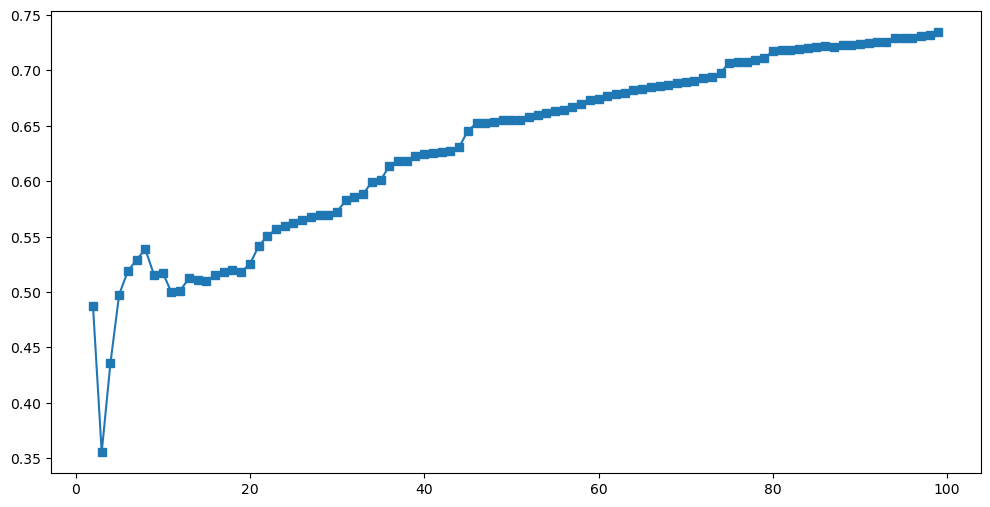

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 100), scores, marker='s');

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using dbindex.
[clusteval] >INFO: 100%|████████████████████████| 98/98 [00:02<00:00, 34.46it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [99].
[clusteval] >INFO> Fin.


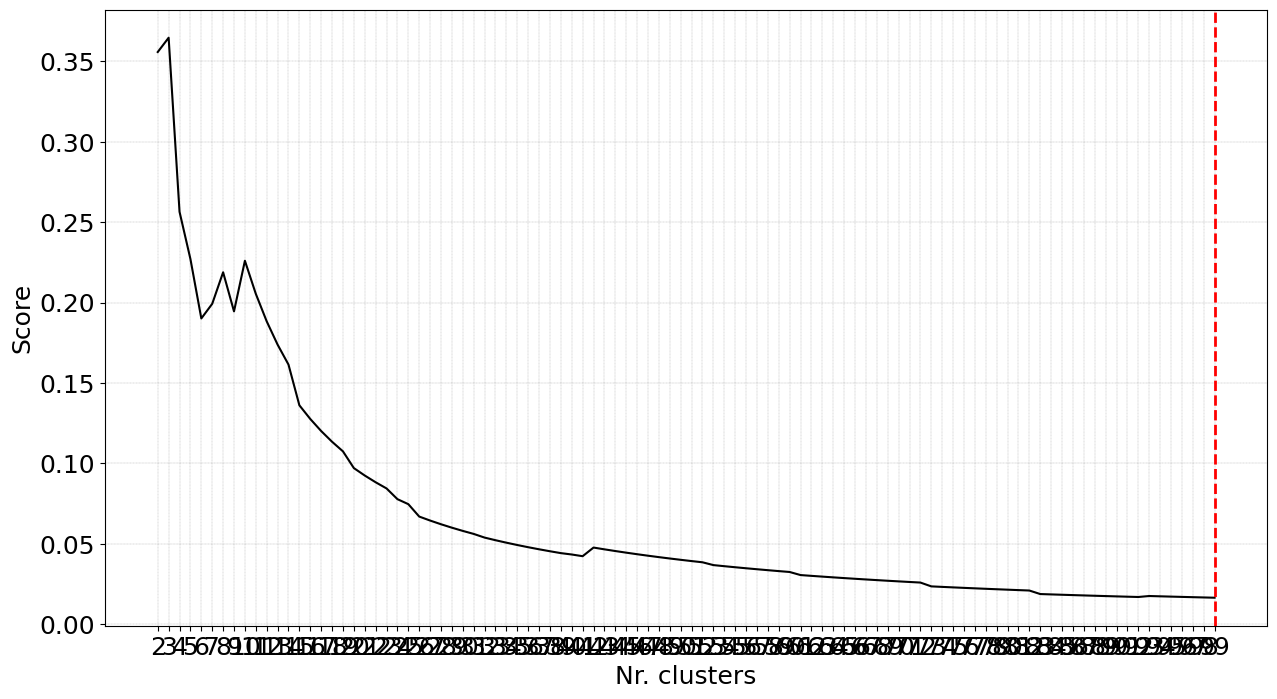

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 99, average silhouette_score=0.500
[clusteval] >WARNING> Colormap [tab20c] can not create [99] unique colors! Available unique colors: [20].


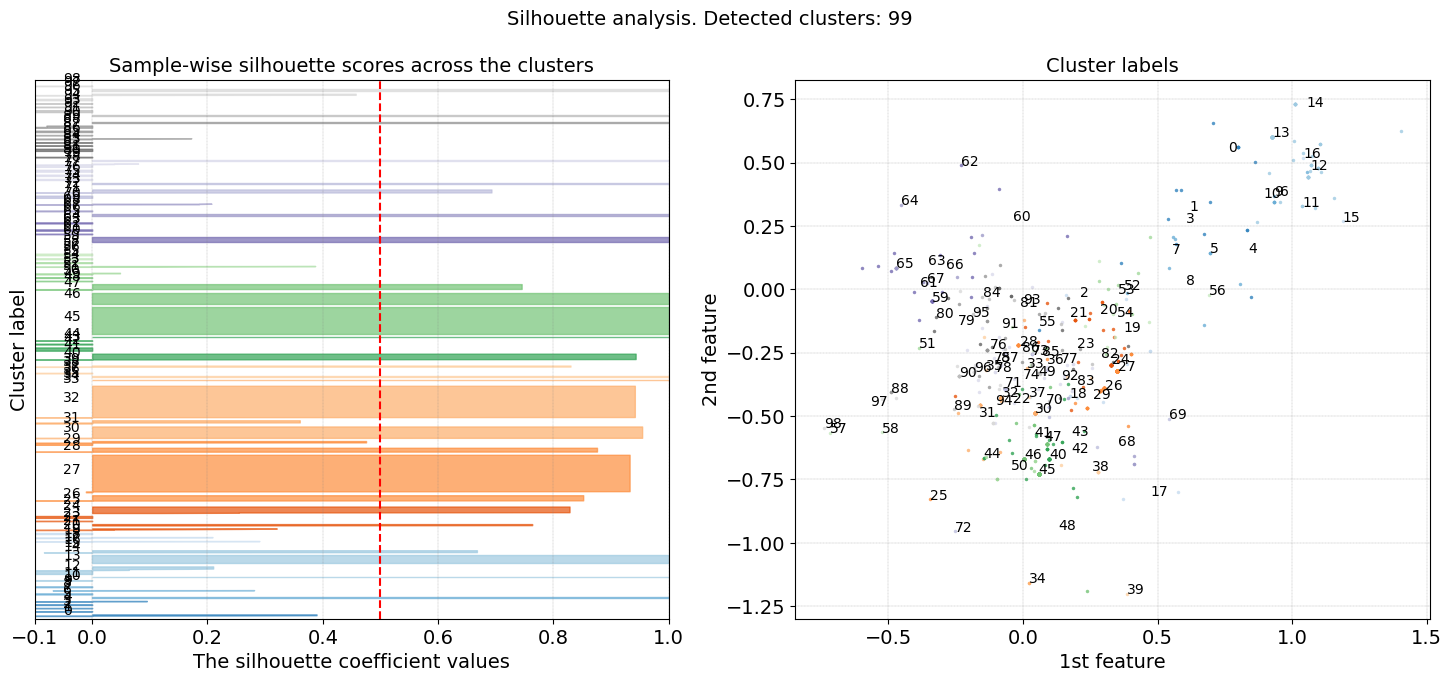

[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
/Users/ataganova/anaconda3/lib/python3.10/site-packages/colourmap/colourmap.py:540: RuntimeWarning: invalid value encountered in divide
  out = (X - x_min) / (x_max - x_min)
[clusteval] >INFO> Set alpha based on density because of the parameter: [opaque]
[clusteval] >INFO> Create scatterplot
[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=3.687. Be patient now..
[clusteval] >INFO> Compute cluster labels.


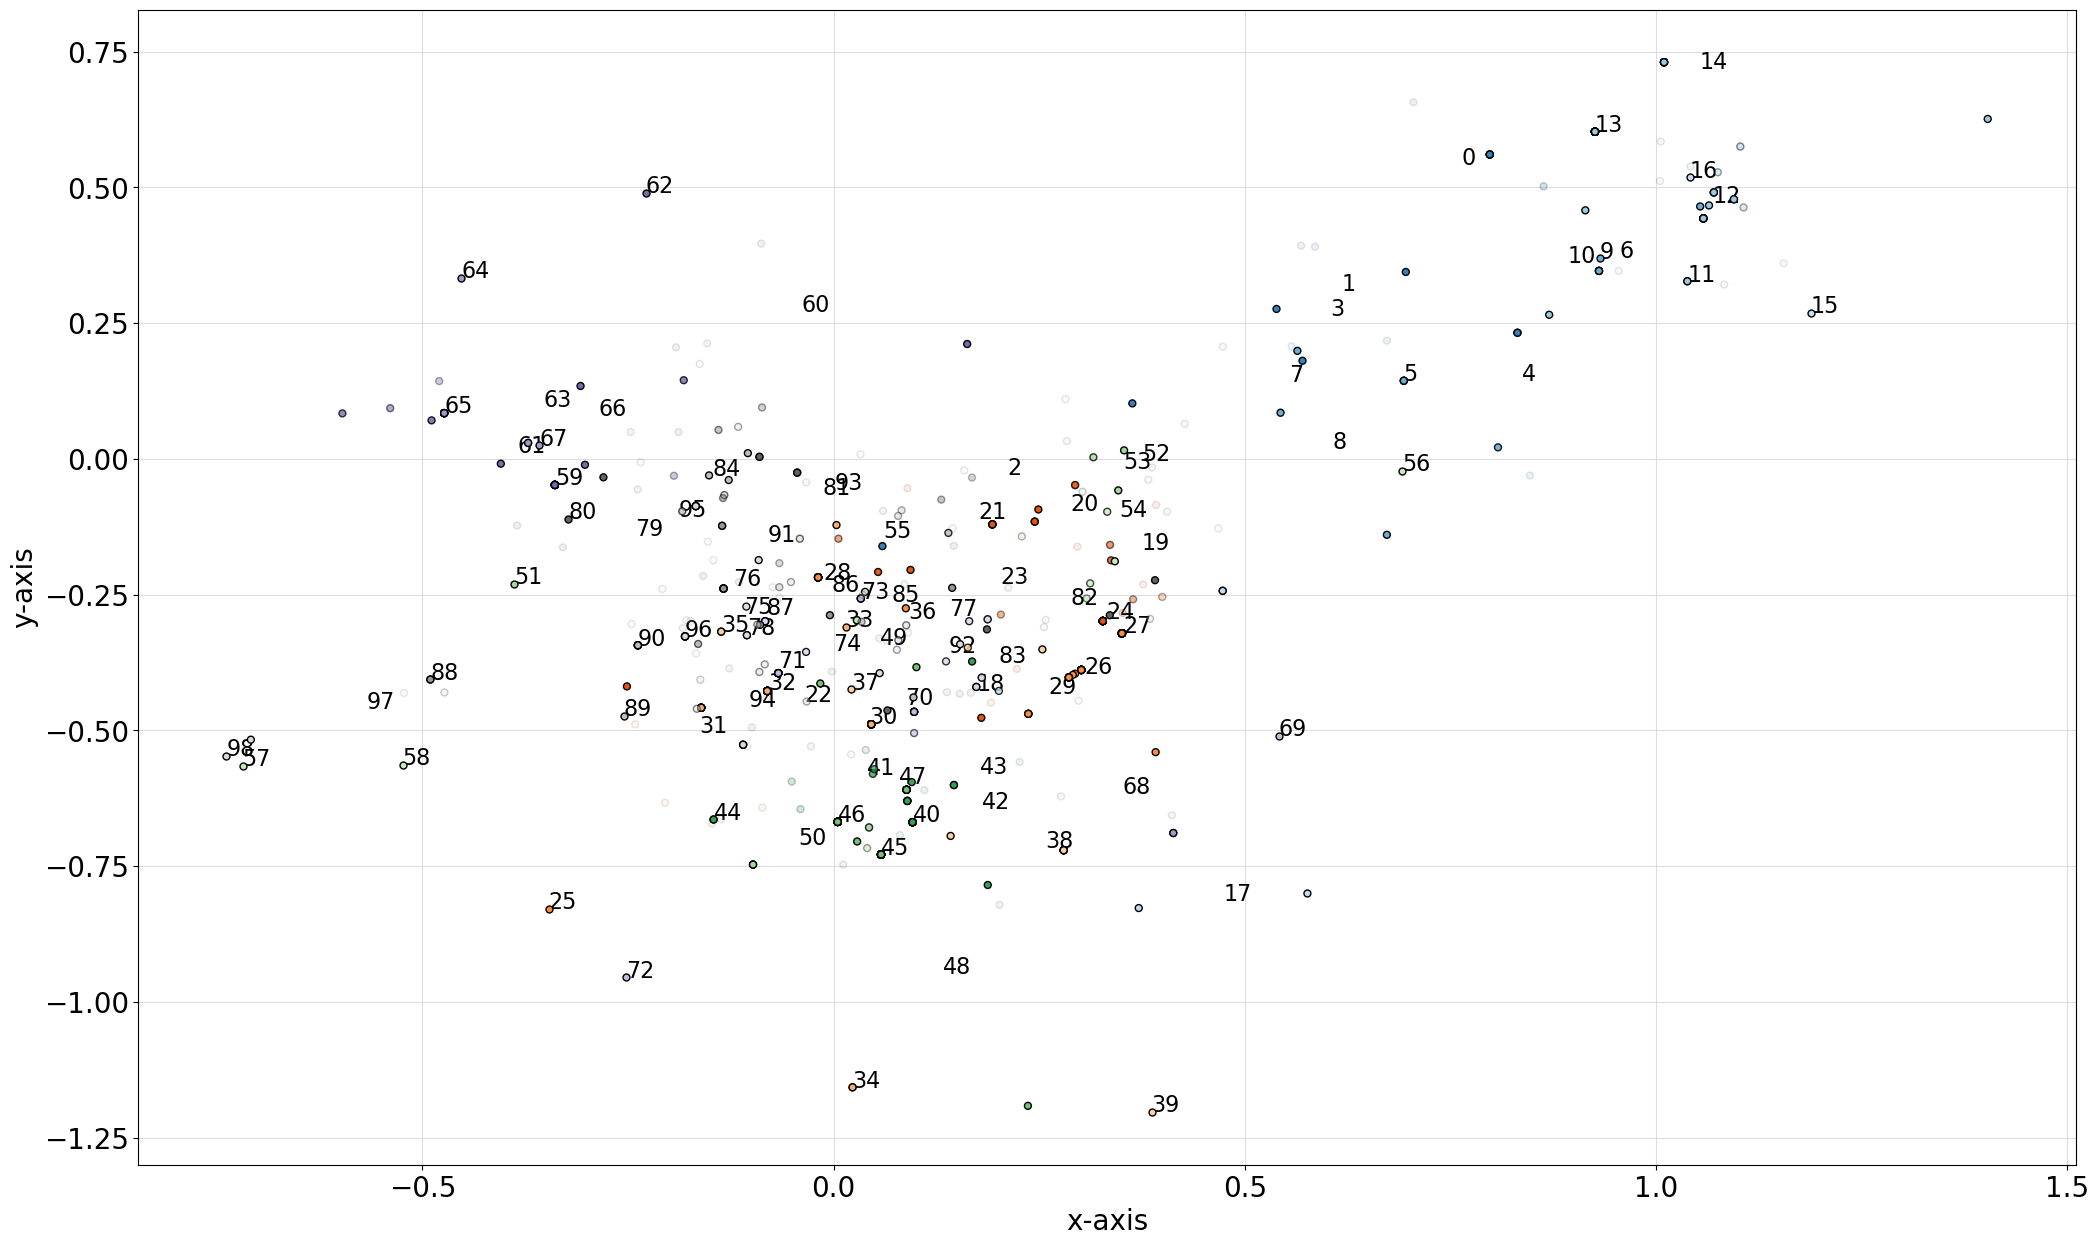

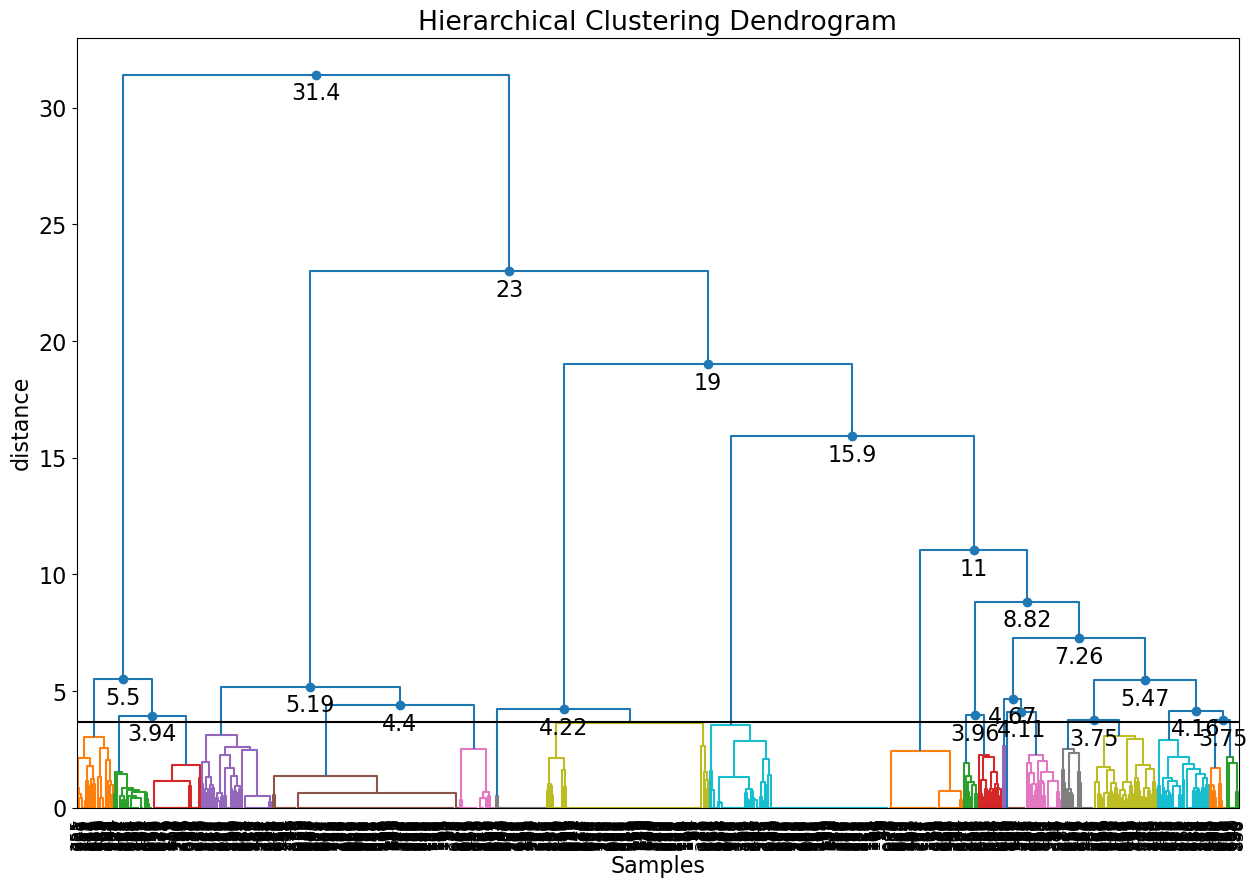

In [10]:
from clusteval import clusteval

ce = clusteval(cluster='agglomerative', evaluate='dbindex', max_clust=100)

# Cluster evaluation
results = ce.fit(ft_vectors)

# Make plots
ce.plot();
ce.plot_silhouette();
ce.scatter();
ce.dendrogram();